In [ ]:
import torch
from previous_chapter import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 추론 시에는 드롭아웃을 비활성화y

In [2]:
import tiktoken
from previous_chapter import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"출력 텍스트: {token_ids_to_text(token_ids, tokenizer)}")

출력 텍스트: Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [6]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) 
print(probas.shape) 
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("토큰 ID:\n", token_ids)
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(targets[0], tokenizer)}")
print(f"두 번째 샘플의 출력: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.Size([2, 3, 50257])
토큰 ID:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
첫 번째 샘플의 타깃:  effort moves you
두 번째 샘플의 출력:  Armed heNetflix


In [7]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # [2, 3, 50257]
print("텍스트 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("텍스트 2:", target_probas_2)

텍스트 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
텍스트 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [8]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)


In [9]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [11]:
print("로짓 크기:", logits.shape)
print("타깃 크기:", targets.shape)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("펼친 로짓:", logits_flat.shape)
print("펼친 타깃:", targets_flat.shape)

로짓 크기: torch.Size([2, 3, 50257])
타깃 크기: torch.Size([2, 3])
펼친 로짓: torch.Size([6, 50257])
펼친 타깃: torch.Size([6])


In [12]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [13]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("문자:", total_characters)
print("토큰:", total_tokens)


문자: 20479
토큰: 5145


In [14]:
from previous_chapter import create_dataloader_v1

# 훈련 세트 비율
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

print("훈련 데이터 로더:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n검증 데이터 로더:")
for x, y in val_loader:
    print(x.shape, y.shape)

훈련 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

검증 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")


model.to(device) 

torch.manual_seed(123) 

with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("훈련 손실:", train_loss)
print("검증 손실:", val_loss)

Using cpu device.
훈련 손실: 10.98758347829183
검증 손실: 10.981106758117676


In [18]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step() 
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")

        # 샘플 텍스트 출력
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # 간결한 출력 포맷
    model.train()

In [19]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"훈련 소요 시간: {execution_time_minutes:.2f}분.")

에포크 1 (Step 000000): 훈련 손실 9.781, 검증 손실 9.933
에포크 1 (Step 000005): 훈련 손실 8.111, 검증 손실 8.339
Every effort moves you,,,,,,,,,,,,.                                     
에포크 2 (Step 000010): 훈련 손실 6.661, 검증 손실 7.048
에포크 2 (Step 000015): 훈련 손실 5.961, 검증 손실 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
에포크 3 (Step 000020): 훈련 손실 5.726, 검증 손실 6.600
에포크 3 (Step 000025): 훈련 손실 5.201, 검증 손실 6.348
Every effort moves you, and I had been.                                            
에포크 4 (Step 000030): 훈련 손실 4.417, 검증 손실 6.278
에포크 4 (Step 000035): 훈련 손실 4.069, 검증 손실 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
에포크 5 (Step 000040): 훈련 손실 3.732, 검증 손실 6.160
Every effort moves you know it was not that the picture--I had the fact by the last I had been--his, and in the            "Oh, and he said, and d

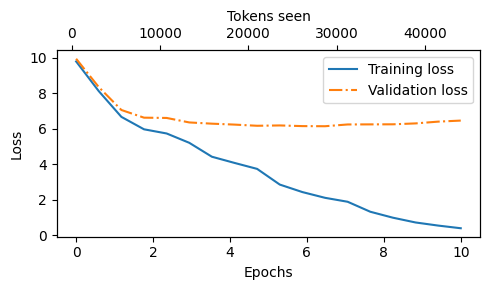

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) 

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [21]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


In [22]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

def print_sampled_tokens(probas):
    torch.manual_seed(123) # 재현가능성을 위한 랜덤 시드
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

forward
forward
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


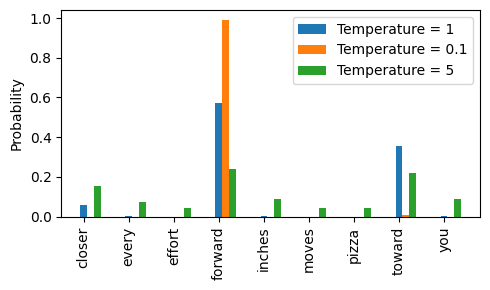

In [23]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5] 

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [24]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("탑-k 로짓:", top_logits)
print("탑-k 위치:", top_pos)

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

탑-k 로짓: tensor([6.7500, 6.2800, 4.5100])
탑-k 위치: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [26]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 탑-k 샘플링으로 로짓 필터링
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 온도 스케일링
        if temperature > 0.0:
            logits = logits / temperature

            logits = logits - logits.max(dim=-1, keepdim=True).values
            probs = torch.softmax(logits, dim=-1)  

            idx_next = torch.multinomial(probs, num_samples=1)

        # 온도 스케일링을 사용하지 않는 경우 그리디 샘플링 사용
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [27]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


In [ ]:
torch.save(model.state_dict(), "verdict_model.pth")

model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

model.load_state_dict(torch.load("verdict_model.pth", map_location=device, weights_only=True))
model.eval()

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "verdict_model_and_optimizer.pth"
)

In [34]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
print("설정:", settings)
print("파라미터 딕셔너리 키:", params.keys())
print(params["wte"])
print("토큰 임베딩 가중치 텐서의 차원:", params["wte"].shape)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 20.3kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 1.04MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 40.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [09:09<00:00, 905kiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.65MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 702kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 690kiB/s] 


설정: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
파라미터 딕셔너리 키: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
토큰 임베딩 가중치 텐서의 차원: (50257, 768)


In [35]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"  # 모델 이름
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [36]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"크기가 다릅니다. left: {left.shape}, right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [37]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [38]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


